<h1 style="color:green; font-family:candara; font-size:300%; text-align:center;"> 
    Credit card Default
</h1>

***

The dataset used to make this notebook can be found [here](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score,roc_curve


#Options for pandas
pd.options.display.max_colwidth = 50 #show more content in the dataframes

Now, let's import the dataset

In [2]:
# On Windows path is with "\\" instead of "/"
df = pd.read_csv("C:\\Users\\cuspi\\Documents\\Databases\\UCI_Credit_Card.csv")

Let's see some information about this dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

Ok, now let's do some cosmetic changes to the dataframe

In [4]:
df.columns = df.columns.str.lower() # Let's not shout at each other...
df = df.rename(columns={'default.payment.next.month':'target', 'pay_0':'pay_1'}) # The target name was too long and the pay_n started on 0 and skipped 1...
df.loc[df.sex==2, 'sex'] = 0 # Sets the Female column value to 0 (to later make a boolean out of this)
df.loc[(df.education > 5)|(df.education==0), 'education'] = 5 # There are some education categories that are unknown 

More often than not it is useful to change some data types:

In [5]:
df = df.astype({'sex':'bool', 'target':'bool'})
# df.iloc[:,3:5] = df.iloc[:,3:5].astype('category')
# df.iloc[:,6:12] = df.iloc[:,6:12].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
id           30000 non-null int64
limit_bal    30000 non-null float64
sex          30000 non-null bool
education    30000 non-null int64
marriage     30000 non-null int64
age          30000 non-null int64
pay_1        30000 non-null int64
pay_2        30000 non-null int64
pay_3        30000 non-null int64
pay_4        30000 non-null int64
pay_5        30000 non-null int64
pay_6        30000 non-null int64
bill_amt1    30000 non-null float64
bill_amt2    30000 non-null float64
bill_amt3    30000 non-null float64
bill_amt4    30000 non-null float64
bill_amt5    30000 non-null float64
bill_amt6    30000 non-null float64
pay_amt1     30000 non-null float64
pay_amt2     30000 non-null float64
pay_amt3     30000 non-null float64
pay_amt4     30000 non-null float64
pay_amt5     30000 non-null float64
pay_amt6     30000 non-null float64
target       30000 non-null bool
dtypes: bool(2), 

In [7]:
df.isna().sum().sum()

0

Now it's a good moment to explain a little bit the data:

- **ID**: unique identifier
- **limit_bal**: amount in New Taiwan (NT) dollars
- **sex**: False=female, True=male
- **education**: 1=grad school, 2=university, 3=high school, 4=others, 5=unknown
- **marriage**: 1=married, 2=single, 3=divorced
- **age**: in years
- **pay_n**: Repayment status (n=1 for Sep 2005 and goes backwards) IF NEGATIVE: -2= no consumption, -1=paid in full, 0=use of revolving credit. IF POSITIVE: k= payment delay for k months
- **bill_amtn**: Amount of bill statement (n=1 for Sep 2005 and goes backwards)
- **pay_amtn**: Amount of previous payment (n=1 for Sep 2005 and goes backwards)
- **target**: Default payment? (True if answer is yes)

In [8]:
df.describe()

,id,limit_bal,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.853767,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,8660.398374,129747.661567,0.784391,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,1.000000,10000.000000,1.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,15000.500000,140000.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,22500.250000,240000.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,30000.000000,1000000.000000,5.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [9]:
df = pd.get_dummies(df, columns=['education'], sparse=True , dtype=int)

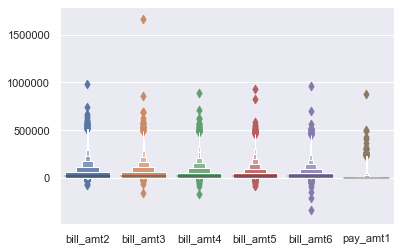

In [10]:
sns.boxenplot(data=df.iloc[:,12:18]);

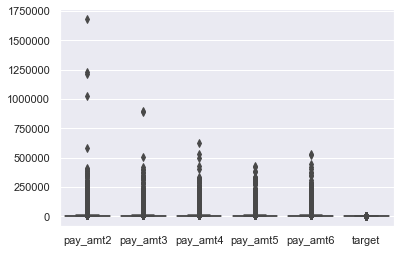

In [11]:
sns.boxplot(data=df.iloc[:,18:24]);

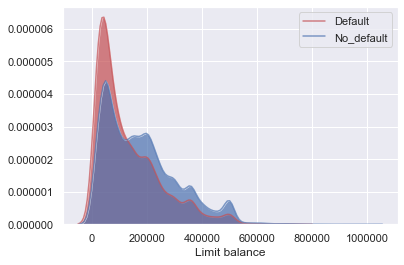

In [12]:
sns.kdeplot(df[df.target].limit_bal, cumulative=False, shade=True, alpha=.7, color='r', label='Default');
sns.kdeplot(df[~(df.target)].limit_bal, cumulative=False, shade=True, alpha=.7, label='No_default');
plt.xlabel('Limit balance');

Since each feature usually uses its own metrics and units, it is better to standarise numerical data 

In [13]:
ss = StandardScaler(with_mean=True, with_std=True)

#First let's make a list of the data types that are numeric, excluding the id
# numerics_list = df.select_dtypes(np.number).iloc[:,1:].columns.tolist()

Now let's transform the data

In [14]:
# data_st = ss.fit_transform(df[numerics_list] )
data_st = ss.fit_transform(df.drop(columns=['id'] ))
data_st = pd.concat([pd.DataFrame(data_st),#, columns=df.columns[1:]),
                     df.target], axis=1);

In [15]:
data_st.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,target
0,-1.136720,-0.810161,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,...,-0.308063,-0.314136,-0.293382,1.876378,-0.738375,1.0669,-0.442752,-0.064163,-0.10786,True
1,-0.365981,-0.810161,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,...,-0.244230,-0.314136,-0.180878,1.876378,-0.738375,1.0669,-0.442752,-0.064163,-0.10786,True
2,-0.597202,-0.810161,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.244230,-0.248683,-0.012122,-0.532942,-0.738375,1.0669,-0.442752,-0.064163,-0.10786,False
3,-0.905498,-0.810161,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.237846,-0.244166,-0.237130,-0.532942,-0.738375,1.0669,-0.442752,-0.064163,-0.10786,False
4,-0.905498,1.234323,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,...,0.266434,-0.269039,-0.255187,-0.532942,-0.738375,1.0669,-0.442752,-0.064163,-0.10786,False


In [16]:
data_st.describe()#Just checking everything has mean=0 and std_dev=1

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,2.436569e-17,1.601398e-14,-2.564186e-15,-7.286024e-17,-7.559566e-17,-1.586202e-15,-1.135055e-16,-3.630355e-15,-7.266021e-16,-4.965398e-15,...,-1.300675e-15,-1.950606e-16,-2.968200e-16,-5.318801e-17,-3.978699e-15,-4.276350e-15,7.212971e-16,-3.849795e-15,-7.973458e-15,3.140146e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.213794e+00,-8.101607e-01,-2.973147e+00,-1.571479e+00,-1.764843e+00,-1.558876e+00,-1.532192e+00,-1.521944e+00,-1.530046e+00,-1.486041e+00,...,-2.968013e-01,-3.080626e-01,-3.141361e-01,-2.933821e-01,-5.329416e-01,-7.383746e-01,-9.372952e-01,-4.427518e-01,-6.416291e-02,-1.078600e-01
25%,-9.054983e-01,-8.101607e-01,-1.057295e+00,-8.120745e-01,-8.749911e-01,-7.235699e-01,-6.966635e-01,-6.665987e-01,-6.475648e-01,-6.164517e-01,...,-2.746506e-01,-2.891680e-01,-2.976091e-01,-2.867584e-01,-5.329416e-01,-7.383746e-01,-9.372952e-01,-4.427518e-01,-6.416291e-02,-1.078600e-01
50%,-2.118326e-01,-8.101607e-01,8.585573e-01,-1.611565e-01,1.486052e-02,1.117361e-01,1.388648e-01,1.887461e-01,2.349165e-01,2.531374e-01,...,-1.945673e-01,-2.123132e-01,-2.159561e-01,-2.090042e-01,-5.329416e-01,-7.383746e-01,-9.372952e-01,-4.427518e-01,-6.416291e-02,-1.078600e-01
75%,5.589071e-01,1.234323e+00,8.585573e-01,5.982479e-01,1.486052e-02,1.117361e-01,1.388648e-01,1.887461e-01,2.349165e-01,2.531374e-01,...,-4.093230e-02,-5.188511e-02,-5.026084e-02,-6.837436e-02,-5.329416e-01,1.354326e+00,1.066900e+00,-4.427518e-01,-6.416291e-02,-1.078600e-01
max,6.416528e+00,1.234323e+00,2.774410e+00,4.720729e+00,7.133674e+00,6.794184e+00,6.823091e+00,7.031505e+00,7.294767e+00,7.209850e+00,...,5.059528e+01,3.933218e+01,2.760363e+01,2.944510e+01,1.876378e+00,1.354326e+00,1.066900e+00,2.258602e+00,1.558533e+01,9.271274e+00


In [17]:
data_st = pd.melt(data_st, id_vars='target', 
                  var_name='features', value_name='value')

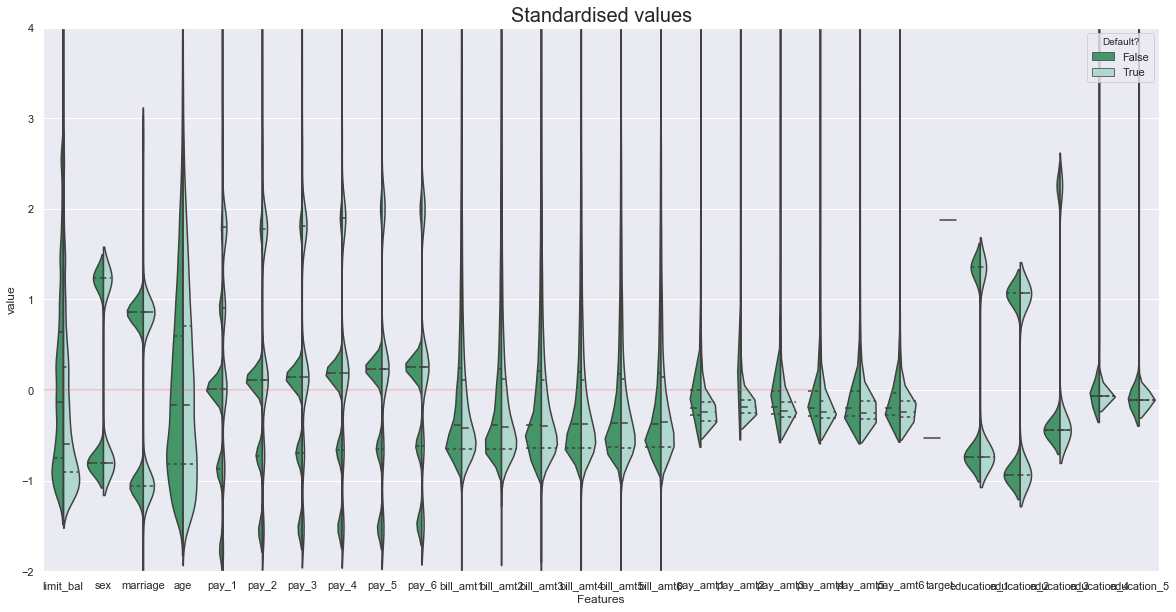

In [18]:
plt.figure(figsize=(20,10))
plt.plot([-1,19], [0,0], color='r',alpha=.3)
ax = sns.violinplot(y='value', x='features', hue='target', 
               data=data_st,
              split=True, inner='quart', palette='BuGn_r');
plt.legend(title='Default?')
plt.ylim([-2,4]);
plt.xlabel('Features', size=12)
plt.title('Standardised values', size=20)
ax.set_xticklabels(df.columns[1:]);

## Training

Before starting to train a model it is important to choose the size of the training set. 
Here  I have decided to make an 80% (train) - 20% (test) division. 

In [19]:
from sklearn.model_selection import train_test_split, learning_curve

y = df.target
X = df.drop('target', axis=1)

# Divide the data to train and test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [20]:
def rescale(df, sel_col):
    #First make a copy of the dataframe
    scaled_features = df.copy()
    #Choose the features
    features =  scaled_features[sel_col]
    #Scale them and get an np.array
    features = ss.fit_transform(features.values)
    #Assign the array to the selected columns
    scaled_features[sel_col] = features
    return scaled_features

# # Here we fit and transform the X_train and with those same parameters we transform X_test
ss = StandardScaler()
selected = ['limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

# X_train = pd.DataFrame(ss.fit_transform(X_train), columns=df.columns[1:]) #fit and transform
# X_test = pd.DataFrame(ss.transform(X_test), columns=df.columns[1:] ) #transform

In [21]:
X_train = rescale(X_train, selected)
X_test = rescale(X_test, selected)

X_train.head()

,id,limit_bal,sex,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,education_1,education_2,education_3,education_4,education_5
3225,3226,-1.140959,False,1,44,0,0,2,0,0,...,-0.252890,-0.243573,-0.247392,-0.316319,-0.296449,0,0,1,0,0
11815,11816,0.712614,False,2,30,-1,-1,-1,-1,-1,...,-0.241199,-0.292157,-0.290474,-0.305439,-0.279808,0,1,0,0,0
7338,7339,-1.140959,True,1,39,2,0,0,0,0,...,-0.188888,-0.249392,-0.266769,-0.218734,-0.296449,0,1,0,0,0
14980,14981,-1.063726,True,1,23,2,2,2,2,2,...,-0.246490,-0.170843,-0.247392,-0.316319,-0.256691,0,1,0,0,0
27167,27168,-1.218191,True,1,29,0,0,0,0,0,...,-0.167554,-0.214481,-0.253851,-0.118513,-0.296449,0,1,0,0,0


## Correlation matrix
This visually helps to find the most important features (without mixing them by a preprocess like PCA)

Remember that the pearson coefficient is considered to be:
- small for $|r|<.3$
- medium for $.3<|r|<.5$
- large for $.5<|r|<1$

The highest correlation between 'target' and 'features' comes from
 pay_1          0.324794
pay_2          0.263551
pay_3          0.235253
pay_4          0.216614
pay_5          0.204149
pay_6          0.186866
limit_bal     -0.153520
pay_amt1      -0.072929
pay_amt2      -0.058579
pay_amt4      -0.056827
pay_amt3      -0.056250
pay_amt5      -0.055124
pay_amt6      -0.053183
education_1   -0.051328
sex            0.039961
education_5   -0.037899
education_2    0.036467
education_3    0.032403
education_4   -0.025397
marriage      -0.024339
Name: target, dtype: float64 



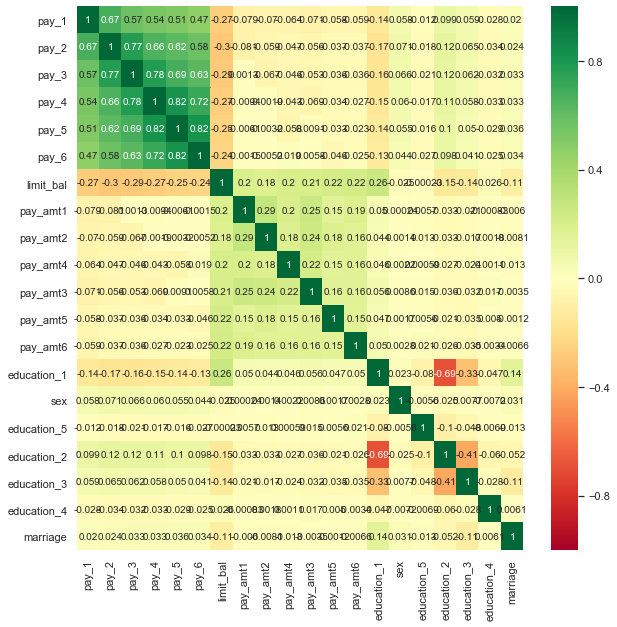

In [22]:
def heat_corr(X, y, n_features=6 ):
    '''This function takes the features matrix (X) and the target vector (y) and gives back an ORDERED correlation heat map.
    Needs seaborn, pandas and numpy
    X = features
    y = target
    n_features = number of features to focus on
    '''
    corrmatrix = pd.concat([X, y],axis=1).corr()
    # Get the names
    top_corr_features = corrmatrix.index
    plt.figure(figsize=(10,10))
      
    # Take the absolute value of the correlation matrix
    A = corrmatrix.apply(np.absolute)
    # Highest correlated functions to the target!!!
    # This means we get a "measure" of how important each feature is
    important = A.sort_values('target', ascending=False).iloc[1:].index.to_list()
    l = corrmatrix[important].loc['target']
#     ordered_matrix = corrmatrix #corrmatrix[important].reindex(important).iloc[:n_features,:n_features]#.sort_values(by=important)        
    ordered_matrix = corrmatrix[important].reindex(important).iloc[:n_features,:n_features]#.sort_values(by=important)    
    
    # Plot heat map
    plot = sns.heatmap(ordered_matrix,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
        
    return (plot, print('The highest correlation between \'target\' and \'features\' comes from\n', l[:n_features], '\n') )
    


heat_corr(df.drop('target', axis=1), df.target, n_features=20);

This means that the only variable with a medium pearson coefficient is the last repayment status. Of course pay_2, pay_3, pay_4, pay_5 and pay_6 do have some correlation but they're not really independent from pay_1. As a matter of fact, we can deduce that if pay_1=k (for some positive k), pay_2 will necessarily be equal to k-1.

A large positive value of pay_1 means that there have been many months in which the client has _defaulted_. This means that someone who has defaulted before is prone to not pay fully and default again 
As a matter of fact, the correlation amongst such values is quite high.

# ML models
## Naive Bayes

We now apply Gaussian NB, where there are no parameters to be tuned.

We will calculate this model's f-score and will visualize how well it did with with a confussion matrix. 

 Raw accuracy for GNB = 72.583% 
 accuracy_score function for GNB gives = 72.583% 
 f1_score function for GNB gives = 50.046% 
 Model parameters = {'priors': None, 'var_smoothing': 1e-09} 



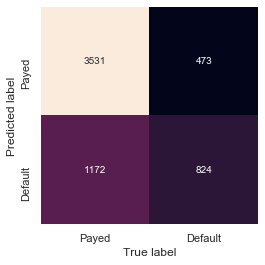

In [23]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

#In the following plot the Transpose of the matrix gives the correct labeling that I like in the figure
mat = confusion_matrix(y_test, y_predicted).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=['Payed', 'Default'] , yticklabels=['Payed', 'Default'] )

plt.xlabel('True label')
plt.ylabel('Predicted label');

#print(y_predicted.sum(), y_test.sum() )

print(' Raw accuracy for GNB = {:.3f}%'.format( (mat[0,0] + mat[1,1])/len(y_test)*100 )
      ,'\n accuracy_score function for GNB gives = {:.3f}%'.format(accuracy_score(y_test, y_predicted)*100 )
      ,'\n f1_score function for GNB gives = {:.3f}%'.format( f1_score(y_test, y_predicted)*100 )
      ,'\n Model parameters =', model.get_params(),'\n'
     )

#We can compare with the usual metrics result:
#print(metrics.classification_report(y_predicted, y_test, digits=5) )

## ROC curve 
A Receiver Operating Characteristic curve (known as **ROC** curve) is basically a plot where we compare the probability of having a false alarm (false positives on the X-axis) with the probability of detection (true positives).
We'll define a function to plot it and we'll use it with our models:

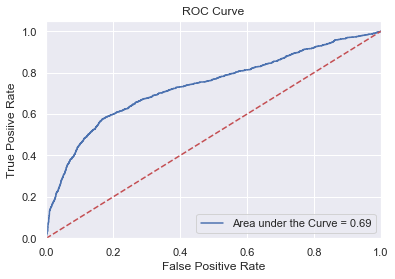

In [24]:
def plot_roc_curve(model, X_test, y_test):
    
    #Get the area under the curve
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    
    false_pr, true_pr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])
    
    plt.figure()
    plt.plot(false_pr, true_pr, label = 'Area under the Curve = {:0.2f}'.format(roc_auc) )
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posiive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    return plt.show()

#Now let's use it for our GNB model
plot_roc_curve(model, X_test, y_test)

## SVC
We should select only some of the features to predict.
Based on the fact that pay_n are not independent, we will only  keep the 3 most important (not highly correlated) features: **pay_1**, **limit_bal** and  **pay_amt1** 

In [25]:
feat=['pay_1', 'limit_bal', 'pay_amt1']
X_train = X_train.loc[:,feat]
X_test = X_test.loc[:,feat]

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#We'll use a linear kernel
model = SVC(kernel='linear',  C=1, random_state=0, probability=True, class_weight='balanced')
model.fit(X_train, y_train) # Train the model to begin the test

# model.get_params().keys()  # What can be tuned?

# Optimisation of hyper-parameters fot this dataset
param_grid = {'C': [.1, 1, 10,100],
              'gamma': [0.001, 0.005,.05]}
grid = GridSearchCV(model, param_grid, cv=5, verbose=True, n_jobs=-1)

In [27]:
model.get_params().keys() # What can be tuned?

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [28]:
%time grid.fit(X_train.loc[:,feat], y_train)
grid.best_params_  #Best params!

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 92.7min finished


Wall time: 1h 33min 46s


{'C': 1, 'gamma': 0.001}

Wall time: 765 ms
 Raw accuracy for SVC = 78.583% 
 accuracy_score function for SVC gives = 78.583% 
 f1_score function for SVC gives = 51.159% 

 Model parameters = {'C': 1, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


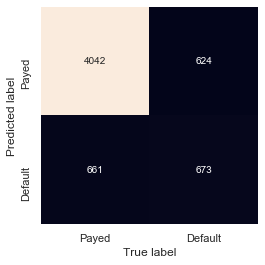

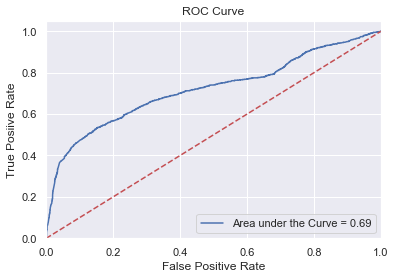

In [29]:
model = grid.best_estimator_ #Best model in town 😎

%time y_predicted = model.predict(X_test.loc[:,feat])

#In the following plot the Transpose of the matrix gives the correct labeling that I like in the figure
mat = confusion_matrix(y_test, y_predicted).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=['Payed', 'Default'] , yticklabels=['Payed', 'Default'] )
plt.xlabel('True label')
plt.ylabel('Predicted label');

#print(y_predicted.sum(), y_test.sum() )

print(' Raw accuracy for SVC = {:.3f}%'.format( (mat[0,0] + mat[1,1])/len(y_test)*100 )
      ,'\n accuracy_score function for SVC gives = {:.3f}%'.format(accuracy_score(y_test, y_predicted)*100 )
      ,'\n f1_score function for SVC gives = {:.3f}%'.format( f1_score(y_test, y_predicted)*100 )
      ,'\n\n Model parameters =', model.get_params()     )

# print(accuracy_score(y_test, y_predicted), '\n', f1_score(y_test, y_predicted) )
##f1score

#Apply our plot ROC function
plot_roc_curve(model, X_test, y_test)

## Logistic regression

Arguably the best model to predict an outcome in this problem will be a logistic regression. 

 Raw accuracy for LogReg = 82.183% 
 accuracy_score function for LogReg gives = 82.183% 
 f1_score function for LogReg gives = 39.227% 

 Model parameters = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


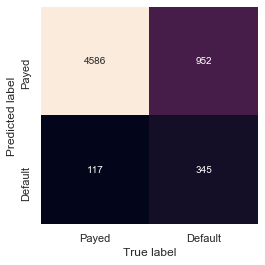

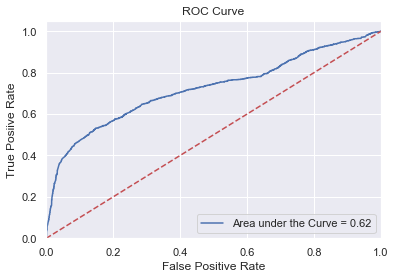

In [30]:
from sklearn.linear_model import LogisticRegression

#Use the model:
model = LogisticRegression(solver='saga' ,penalty='elasticnet', l1_ratio=0.1)
model.fit(X_train, y_train)
# model.get_params().keys()  # What can be tuned?

y_predicted = model.fit(X_train, y_train).predict(X_test)

#In the following plot the Transpose of the matrix gives the correct labeling that I like in the figure
mat = confusion_matrix(y_test, y_predicted).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=['Payed', 'Default'] , yticklabels=['Payed', 'Default'] )

plt.xlabel('True label')
plt.ylabel('Predicted label');

#print(y_predicted.sum(), y_test.sum() )

print(' Raw accuracy for LogReg = {:.3f}%'.format( (mat[0,0] + mat[1,1])/len(y_test)*100 )
      ,'\n accuracy_score function for LogReg gives = {:.3f}%'.format(accuracy_score(y_test, y_predicted)*100 )
      ,'\n f1_score function for LogReg gives = {:.3f}%'.format( f1_score(y_test, y_predicted)*100 )
      ,'\n\n Model parameters =', model.get_params()     )

# print(accuracy_score(y_test, y_predicted), '\n', f1_score(y_test, y_predicted) )
##f1score

# apply our plot ROC function
plot_roc_curve(model, X_test, y_test)

## Random Forests

 Raw accuracy for RandForest = 77.383% 
 accuracy_score function for RandForest gives = 77.383% 
 f1_score function for RandForest gives = 38.901% 

 Model parameters = {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


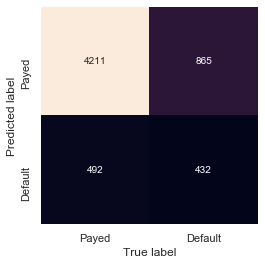

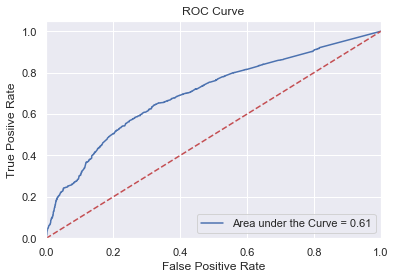

In [31]:
from sklearn.ensemble import RandomForestClassifier

#Use the model:
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train)
# model.get_params().keys()  # What can be tuned?

# Optimisation of hyper-parameters fot this dataset
param_grid = {'n_estimators': [10,50,100, 200] }

grid = GridSearchCV(model, param_grid, cv=7)

grid.fit(X_train, y_train)


#we can actually straightforward use the gridsearch as a model!!! #🤦‍
y_predicted = grid.predict(X_test)

#In the following plot the Transpose of the matrix gives the correct labeling that I like in the figure
mat = confusion_matrix(y_test, y_predicted).T
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=['Payed', 'Default'] , yticklabels=['Payed', 'Default'] )

plt.xlabel('True label')
plt.ylabel('Predicted label');

#print(y_predicted.sum(), y_test.sum() )

print(' Raw accuracy for RandForest = {:.3f}%'.format( (mat[0,0] + mat[1,1])/len(y_test)*100 )
      ,'\n accuracy_score function for RandForest gives = {:.3f}%'.format(accuracy_score(y_test, y_predicted)*100 )
      ,'\n f1_score function for RandForest gives = {:.3f}%'.format( f1_score(y_test, y_predicted)*100 )
      ,'\n\n Model parameters =', model.get_params()     )

# print(accuracy_score(y_test, y_predicted), '\n', f1_score(y_test, y_predicted) )
##f1score
# apply our plot ROC function
plot_roc_curve(model, X_test, y_test)